In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import random
from intent_classify import IntentClassify
from gensim import corpora, models, similarities,matutils
from fasttext_util import FasttextClassifier
import time
from collections import Counter
import re
from url import Searcher
import pickle
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline


/home/works/data/tools/miniconda2/envs/tfenv.v1.2/lib/python2.7/site-packages/scipy/sparse/lil.py:19: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _csparsetools
/home/works/data/tools/miniconda2/envs/tfenv.v1.2/lib/python2.7/site-packages/scipy/sparse/csgraph/__init__.py:165: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._shortest_path import shortest_path, floyd_warshall, dijkstra,\
/home/works/data/tools/miniconda2/envs/tfenv.v1.2/lib/python2.7/site-packages/scipy/sparse/csgraph/_validation.py:5: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._tools import csgraph_to_dense, csgraph_from_dense,\
/home/works/data/tools/miniconda2/envs/tfenv.v1.2/lib/python2.7/site-packages/scipy/sparse/csgraph/__init__.py:167: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 9

load 1006 user-define jieba dict success!


In [2]:
class word():    
    def __init__(self):
        self.word_to_vec = {}
        self.dictionary = corpora.dictionary.Dictionary()
        self.dic = self.dictionary.load('../util/new/laiye/corpus.dict')
        self.tfidf = models.TfidfModel.load('../util/new/laiye/corpus.tfidf_model')  
        
    def remove_punctuation(self, line):
        rule = re.compile(ur"[^a-zA-Z0-9\u4e00-\u9fa5]")
        line = rule.sub('',line)
        return line        

    def stopwordslist(self, filepath):  
        stopwords = [line.strip() for line in open(filepath, 'r').readlines()]  
        return stopwords  


    # 对句子进行分词  
    def jieba_cut(self, sentence):  
        sentence_seged = jieba.cut(sentence.strip())  
        stopwords = stopwordslist('../util/new/laiye/stopwords.txt')  # 这里加载停用词的路径  
        outstr = ''  
        for word in sentence_seged:  
            if word.encode('utf-8') not in stopwords:  
                if word.encode('utf-8') != '\t' and word != '\t':  
                    outstr += word
                    outstr += " "  
        return outstr.strip().split(' ')

    def get_word2vec(self):
        with open('../util/new/laiye/w2v_sgns_win1_d80.kv') as f:
            data = [x.split(' ') for x in f.readlines()[1:]]
            words = [d[0] for d in data]
            vecs = np.array([d[1: -1] for d in data], dtype= 'float64')
            for i in range(len(words)):
                word = words[i]
                self.word_to_vec[word] = vecs[i]

    def get_tf_idf_of_query(self, query, dic, tfidf):      
        vec_bow = dic.doc2bow(query)
        vec_tfidf = tfidf[vec_bow]
        tp = [0.0] * len(query)
        ids = [tid[0] for tid in vec_tfidf]
        flags = [0] * len(query)
        count = 0.00001
        for j in range(len(query)):
            for i in range(len(ids)):
                if self.dic[ids[i]] == query[j]:
                    tp[j] = vec_tfidf[i][1]
                    flags[j] = 1
                    count += 1
                    break
        sums = sum(tp)
        #print ','.join(query)
        for i in range(len(flags)):
            if flags[i] == 1:
                continue
            tp[i] = 1.0 * sums / count
                    
        # apply l1-norm to tfidf value
        #tfidf = matutils.unitvec(vec_tfidf, norm = 'l1')   
        return tp

    def get_vectors_of_data_cut(self, data):
        vecs = []
        for i in range(len(data)):
            vec = []
            d_line = data[i].split(' ')
            tfidfs = self.get_tf_idf_of_query(d_line, self.dic, self.tfidf)
            s = sum(tfidfs)
            for j in range(len(d_line)):
                if d_line[j].encode('utf-8') in self.word_to_vec:
                    if s == 0:
                        vec.append([0.0] * len(self.word_to_vec['家']))
                    else:
                        vec.append((tfidfs[j] / s) * self.word_to_vec[d_line[j].encode('utf-8')])
            if len(vec) == 0:
                vec.append([0.0] * len(self.word_to_vec['家']))
            vecs.append(np.sum(np.array(vec), axis = 0))
        return np.array(vecs)    
    

In [3]:
class data():
    
    def __init__(self, data_path, text_path, knowledge_path, label_path):
        self.data = open(data_path, 'r').readlines()
        self.knowledge = open(knowledge_path, 'r').readlines()
        self.text_path = text_path
        self.label = open(label_path, 'r').readlines()
        self.indexes = []
        self.labeled_indexes = []
        self.unlabeled_indexes = []
        self.test_indexes = []
        self.questions_match_dict = []
        self.t_map = {}
        self.range = [0.000001,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0]
        self.range_result = {0.05:0, 0.1:0,0.15:0, 0.2:0,0.25:0, 0.3:0,0.35:0, 0.4:0,0.45:0,0.5:0, 0.55:0,0.6:0,0.65:0,0.7:0, 0.75:0,0.8:0,0.85:0,0.9:0,0.95:0, 1.0:0}
        self.dic = {}
        
    def get_texts(self, text_path):
        texts = []
        knowledges = []
        labels = []
        for i in range(len(self.data)):
            for key in self.data[i].split('||'):
                if key.strip() != '':
                    key = key.strip().replace('\n','')
                    texts.append(key) 
                    knowledges.append(self.knowledge[i].strip().replace('\n',''))
                    labels.append(self.label[i].strip().replace('\n',''))
        text_csv = pd.DataFrame({'text':texts, 'knowledge':knowledges, 'label':labels})
        text_csv.to_csv(text_path, index = False, encoding = 'utf-8')
        
    def split_real_labeled_unlabeld_and_test(self):
        self.get_texts(self.text_path)
        data = pd.read_csv(self.text_path)
        l = list(data['text'])
        k = list(data['knowledge'])
        lab = list(data['label'])
        '''
        res = []
        for i in range(len(l)):
            res.append((l[i], i))
        pickle.dump(res, open('total_texts.txt', 'w'))
        '''
        undefined = pd.read_csv('../data/undefined_text.csv')
        labeled, unlabeled = data, undefined
        return labeled, unlabeled
    
    def split_labeled_unlabeld_and_test(self):
        self.get_texts(self.text_path)
        data = pd.read_csv(self.text_path)
        l = list(data['text'])
        k = list(data['knowledge'])
        lab = list(data['label'])
        '''
        res = []
        for i in range(len(l)):
            res.append((l[i], i))
        pickle.dump(res, open('total_texts.txt', 'w'))
        
        import ipdb;
        ipdb.set_trace()
        '''
        unique_knowledge = data['knowledge'].unique()
        self.labeled_indexes = []
        #data = data[data['label'] != '聊天']
        for i in range(len(unique_knowledge)):
            data_of_know = data[data['knowledge'] == unique_knowledge[i]]
            inds = data_of_know.index.tolist()
            random.shuffle(inds)
            if len(inds) < 10:
                self.labeled_indexes = self.labeled_indexes + inds[:int(0.5*len(inds)) + 1]
            else:
                self.labeled_indexes = self.labeled_indexes + inds[:10]
            
        self.indexes = data.index.tolist()
        left_indexes = list(set(self.indexes) - set(self.labeled_indexes))
        random.shuffle(left_indexes)
        self.unlabeled_indexes, self.test_indexes = left_indexes[:int(0.8 * len(left_indexes))], left_indexes[int(0.8 * len(left_indexes)) :]
        labeled, unlabeled, test = data.loc[self.labeled_indexes], data.loc[self.unlabeled_indexes], data.loc[self.test_indexes]
        print len(self.unlabeled_indexes),len(self.test_indexes),len(self.labeled_indexes),len(self.indexes)
        test.to_csv('../data/test_undefined.csv')
        return labeled, unlabeled, test
    
    def trans_i_to_str_dic(self, dic):
        i_to_str_map = pickle.load(open('total_texts.txt'))
        for i in range(len(i_to_str_map)):
            self.t_map[i_to_str_map[i][1]] = i_to_str_map[i][0]
        new_dic = {}
        for key in dic:
            new_dic[self.t_map[key]] = dic[key]
        return new_dic
    
    def get_dict_of_questions(self):
        self.dic = pickle.load(open('../data/xiaolai100000+.txt', 'r'))#pickle.load(open('../data/total_dic_results.txt', 'r'))
        for key in self.dic:
            sim_result = self.dic[key]
            scores = [sim_result[k][2] for k in range(len(sim_result))]
            for m in range(len(scores)):
                for j in range(len(self.range) - 1):
                    if self.range[j] < float(scores[m]) <= self.range[j + 1]:
                        self.range_result[self.range[j + 1]] += 1
        xl = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0]
        col_value = []
        for i in range(len(xl)):
            col_value.append(self.range_result[xl[i]])
        plt.bar(range(5,105,5), col_value)
        plt.show()

        
        def update_unlabeled_data(self, new_undefined_path):
            origin_texts = [key for key in self.dic]
            cur_undefined = pd.read_csv(new_undefined_path)
            cur_texts = list(new_undefined['text'])
            new_texts = list(set(cur_texts) - set(origin_texts))
            return new_texts
        
        return self.dic

In [4]:
class active_learning():
    
    def __init__(self, labeled, unlabeled, test, dic,  k, word_util, map_):
        self.labeled = labeled
        self.unlabeled = unlabeled
        self.test = test
        self.labeled_texts = list(labeled['text'])
        self.unlabeled_texts = list(unlabeled['text'])
        #self.test_texts = list(test['text'])
        self.dic = dic
        #self.real = list(test['knowledge'])
        self.unlabeled_indexes = unlabeled.index.tolist()
        self.k = k
        self.sets = []
        self.map = map_
        self.word_util = word_util
        
    def predict(self):
        pred = []
        print 'now labeled sets size is : ' + str(len(self.labeled_texts))
        for i in self.test.index.tolist():
            results = self.dic[i]
            res_in = []
            for res in results:
                ques, title, score = res
                if ques.encode('utf-8') in self.labeled_texts:
                    knowledge = self.labeled[self.labeled['text'] == ques.encode('utf-8')]['knowledge']
                    knowledge = knowledge.loc[knowledge.index.tolist()[0]]
                    res_in.append(knowledge)
            if len(res_in) == 0:
                res_in.append('聊天')
            sort_dic = sorted(Counter(res_in).items(), key = lambda item:item[1], reverse = True)
            final_pred = sort_dic[0][0]
            pred.append(final_pred)
        real = [self.real[i].decode('utf-8') for i in range(len(self.real))]
        preds = [pred[i].decode('utf-8') for i in range(len(pred))]
        print('classification_report :\n%s' % metrics.classification_report(real, preds)) 
        
    def select_set(self):
        ent_dict = {}
        count_dict = []
        for i in self.unlabeled_indexes[:100001]:
            if self.map[i] not in dic:
                print i, self.map[i]
                break
            results = dic[self.map[i]]
            res_in = []
            if i % 100 == 0:
                print i
            for res in results:
                ques, title, score = res
                if ques.encode('utf-8') in self.labeled_texts and 0.45 <= float(score):
                    knowledge = self.labeled[self.labeled['text'] == ques.encode('utf-8')]['knowledge']
                    knowledge = knowledge.loc[knowledge.index.tolist()[0]]
                    res_in.append((knowledge, float(score)))
            if len(res_in) == 0:
                res_in.append(('聊天',0.0000001))
            counter = {}
            total_score = 0.0000001
            for k in range(len(res_in)):
                if res_in[k][0] not in counter:
                    counter[res_in[k][0]] = 0.0000001
                counter[res_in[k][0]] += res_in[k][1]
                total_score += res_in[k][1]
            ent = 0.0000001
            scores,ents, ent_dic = [], [], {}
            for key in counter:
                scores.append(counter[key] / total_score)
                p = counter[key] / total_score
                logp = np.log2(p)
                ent -= p * logp
            ents.append(ent)     
            ent_dict[i] = ent
            count_dict.append(counter)
        sort_dic = sorted(ent_dict.items(), key = lambda item:item[1], reverse = True)[:self.k]
        cur_set_index = [sort_dic[k][0] for k in range(len(sort_dic))]
        cur_set_entropy = [sort_dic[k][1] for k in range(len(sort_dic))]
        cur_count = []
        for i in range(len(count_dict)):
            if i in cur_set_index:
                cur_count.append(count_dict[i])
        
        return cur_set_index, cur_set_entropy, cur_count
            
    def merge(self, cur_set, cur_set_entropy, cur_count):
        self.sets = [] 
        new_labeled = pd.concat((self.labeled, self.unlabeled.loc[cur_set]), axis = 0)
        dt = pd.DataFrame({'text':[], 'entropy':[], 'index':[], 'count' :[]})
        print 'merge into file : '+ '../data/total_results/entropy_sum' + str(len(new_labeled)) + '.csv'
        dt['text'] = list(self.unlabeled.loc[cur_set,'text'])
        dt['count'] = cur_count
        dt['entropy'] = cur_set_entropy
        dt['index'] = self.unlabeled.loc[cur_set].index.tolist()
        dt.to_csv('../data/total_results/entropy_sum' + str(len(new_labeled)) + '.csv', index = False, encoding = 'utf-8')   
        new_unlabeled = self.unlabeled.drop(cur_set, axis = 0)
        self.labeled = new_labeled
        self.unlabeled = new_unlabeled
        self.labeled_texts = list(self.labeled['text'])
        self.unlabeled_texts = list(self.unlabeled['text'])
        self.unlabeled_indexes = new_unlabeled.index.tolist()        

In [5]:
#if __name__=="__main__":
data_util = data('../data/data.txt', '../data/text.csv', '../data/knowledge.txt', '../data/label.txt')
word_util = word()
word_util.get_word2vec()
#labeled, unlabeled, test = data_util.split_labeled_unlabeld_and_test()
labeled, unlabeled = data_util.split_real_labeled_unlabeld_and_test()
test = None
labeled_texts = labeled['text']
#test_texts = test['text']
#dic = data_util.get_dict_of_questions()

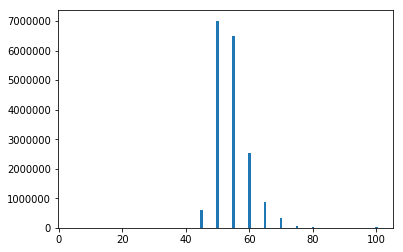

In [6]:
t_dic = data_util.get_dict_of_questions()
dic = data_util.trans_i_to_str_dic(t_dic)

In [7]:
labeled_indexes, unlabeled_indexes = data_util.labeled_indexes, data_util.unlabeled_indexes
al = active_learning(labeled, unlabeled, test, dic, 500, word_util, data_util.t_map)
while len(al.unlabeled_indexes) > 500:
    print 'length of cur unlabeled index is : ' + str(len(al.unlabeled_indexes))
    #al.predict()
    cur_set, cur_set_entropy, cur_count = al.select_set()
    al.merge(cur_set, cur_set_entropy, cur_count)
    break

length of cur unlabeled index is : 104983
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400